In [1]:
import videoIO as vio
import vfeatures as fv
import pandas as pd
import vplot as vp
import vmanipulation as vm

df = pd.read_csv('../data.csv')
filesDir = '../Database/'
df['File'] = df.File.str[-16:]
df['File'] = filesDir + df['File']
df = df.rename(columns={'Time_duration (mm:ss)': 'Time_duration','Time_start (mm:ss.ms)':'Time_start'})

filename = df['File'][0] 
start = df['Time_start'][0]
duration = df['Time_duration'][0]



In [2]:
A = vio.readAudio(filename, duration, start, mono=True)

In [3]:
A = vm.normalize(A,normRange=[-1,1])
A = vm.removeDC(A)

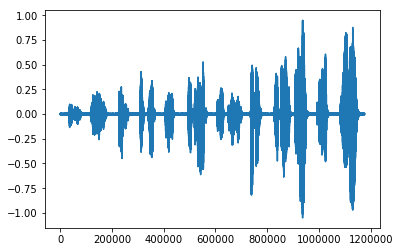

In [4]:
vp.plotAudio(A)

In [170]:
import numpy as np
import matplotlib.pyplot as plt

def plotSpectrum(y,Fs):
    """
    Plots a Single-Sided Amplitude Spectrum of y(t)
    """
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range
    
    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]

    plt.plot(frq,abs(Y),'r') # plotting the spectrum
    plt.xlabel('Freq (Hz)')
    plt.ylabel('|Y(Freq)|')
    
    plt.show()
    
def energy(signal):
    return signal**2    

def dftWindows(windows):
    dftwin = []
    for w  in windows:
        dftw = np.fft.fft(w)
    
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    
def melFrequency(f):
    return 1127 * np.log(1 + f/700)

def bark(f):
    a = 1
    return 13 * a * tan(f/1315.8) + 3.5 * a * tan(f/7518)

def logFrequency(f):
    return np.log2(f/1000)

def logAttackTime(attackStart, attackEnd):
    return np.log10(attackEnd - attackStart)

def temporalIncrease(attackStart, attackEnd, signal, mu = 0, sig = 0.5):
    averageEnergy = np.zeros(attackStart.size)
    for i, (s,e) in enumerate (zip(attackStart, attackEnd)):
        g = gaussian(np.linspace(-0.5, 0.5, e-s), mu, sig)    
        averageEnergy[i] = ( (signal[s:e]**2)*g ).mean()
    return averageEnergy

def temporalCentroid(signal,sampleRate):
    t = np.arange(0,signal.size,1)/sampleRate
    return sum( (signal**2)*t) / sum ((signal**2)) 
    

def findVoicedSegmants(signal, t, hold = 0):
    tVal = signal.max() * t
    signVariationArray = np.diff(np.sign(signal - tVal))
    (signVariationIdx,) = np.nonzero(signVariationArray)
    signVariationIdx = signVariationIdx.astype(float)
    
    signVariationIdx = np.insert(signVariationIdx,-1,float('inf'))
    signVariationIdx[-2:] = signVariationIdx[-1],signVariationIdx[-2]
    
    shiftIdx = np.zeros_like(signVariationIdx)
    shiftIdx[0] = float('-inf')
    shiftIdx[1:] = signVariationIdx[:-1]
    
    endSegments = shiftIdx[(abs(shiftIdx  - signVariationIdx)>hold)][1:]
    startSegments = signVariationIdx[(abs(shiftIdx  - signVariationIdx)>hold)][:-1]
    
    return (np.vstack((startSegments, endSegments)) ).astype(int)

def signalAutoCorrelation(signal, it_limit=None):
    signalLength = signal.size
    
    if it_limit == None:
        it_limit = signalLength
        
    signalCorrelation = np.zeros(it_limit)
    
    for i in range(it_limit):
        signalCorrelation[i] = sum(signal[0:signalLength-i] * signal[i:]) 
    return signalCorrelation


def energyVoicedSegments(signal, t, hold = 0):
    vs = findVoicedSegmants(signal, t, hold)
    energyVoice = 0
    for (s,e) in zip(attackStart, attackEnd):
        energyVoice += sum(energy(signal[s:e]))
    return energyVoice
    
def energyUnvoicedSegments(signal, t, hold = 0):
    return sum(energy(signal)) - energyVoicedSegments(signal,t,hold)


def spectralCentroid(signal, sampleRate):
    
    n = len(signal) # length of the signal
    k = np.arange(n)
    T = n/sampleRate
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range
    
    Y = np.fft.fft(signal) # fft computing and normalization
    Y = Y[range(n//2)]

    F = np.arange(0,len(signal),1)/T
    
    print(frq)
    print(F)
    print(abs(Y))
    
    #plt.plot(frq,abs(Y),'r') # plotting the spectrum
    #plt.xlabel('Freq (Hz)')
    #plt.ylabel('|Y(Freq)|')
    
    #plt.show()
    
    #T = len(y)/Fs
    
    
    #frq = np.arange(len(y))/T # two sides frequency range
    #frq = frq[range(n//2)] # one side frequency range
    
    #frequency = np.arange(len(signal)//2)/sampleRate

#plotSpectrum(A,48000)
spectralCentroid(A,48000)
#vs = findVoicedSegmants(A,0.02,4000)
#attackStart = vs[0,:]
#attackEnd = vs[1,:]
#k = energyVoicedSegments(A, 0.02, hold = 4000)
#k2 = energyUnvoicedSegments(A, 0.02, hold = 4000)
#print(attackStart.size)
#temporalIncrease(attackStart, attackEnd, A)
#print(temporalCentroid(A,48000))
#k = signalAutoCorrelation(A, 12)

#print(k, k2)


[  0.00000000e+00   4.08163265e-02   8.16326531e-02 ...,   2.39998776e+04
   2.39999184e+04   2.39999592e+04]
[  0.00000000e+00   4.08163265e-02   8.16326531e-02 ...,   4.79998776e+04
   4.79999184e+04   4.79999592e+04]
[  1.13509202e-11   1.35475053e-01   1.87234195e-01 ...,   1.20402090e-01
   1.73287787e-01   7.35136288e-02]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import matplotlib.patches as patches
import cv2
import scipy.misc
import dlib
import numpy as np

im = mpimg.imread('../faces/faces3-0.jpg') 

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/home/paula/Desktop/Personality_recognition/shape_predictor_68_face_landmarks.dat')

def rgb2gray(rgbImg):
    return np.dot(rgbImg[...,:3], [0.299, 0.587, 0.114])

gray = rgb2gray(im).astype(np.uint8)
rect = detector(gray,1)

for r in rect:
    
    fig,ax = plt.subplots(1)
    ax.imshow(gray,cmap='gray')
    x = patches.Rectangle((r.left(),r.top()),r.width(),r.height(),linewidth=1,edgecolor='r',facecolor='none')
    #ax.add_patch(x)
    
    s = predictor(gray,r)
    
    for p in list(s.parts()):
        print(p)
        c = patches.Circle( (p.x, p.y) , 5)
        ax.add_patch(c)
        
    plt.show()
        

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2

def saveFrames(filename, frames, region=None):
    if region:
        L, R, T, B = region   
    else:
        L, R, T, B = (0,frames[0].shape[0],0,frames[0].shape[1])
    
    for i, f in enumerate(frames):
        
        cv2.imwrite(filename + str(i) + ".jpg", f[L:R,T:B,::-1])

region = (100, 950, 650, 1250)

for idx, row in df.iterrows():
    fileDir = "../faces/"
    print(idx, row['File'], row['Time_start'], row['Time_duration'])
    frames = vio.readFrames(filename=row['File'], start=row['Time_start'], duration=row['Time_duration'],framedrop=10)
    fileDir = fileDir + 'faces' + str(idx) + '-' 
    print(fileDir)
    saveFrames(fileDir, frames, region=region)


In [ ]:
matplotlib inline
import numpy as np
#import cv2
#import matplotlib.pyplot as plt
#import matplotlib.image as pmimg
#import IPython.display
#import pandas as pd
#from sklearn.model_selection import train_test_split
#import gc
#from matplotlib import gridspec

In [ ]:
# Read data and getting full file path
df = pd.read_csv('../data.csv')
filesDir = '../Database/'
df['File'] = df.File.str[-16:]
df['File'] = filesDir + df['File']
df = df.rename(columns={'Time_duration (mm:ss)': 'Time_duration','Time_start (mm:ss.ms)':'Time_start'})
#print(df.head(5))

In [ ]:
filename = df['File'][0] 
start = df['Time_start'][0]
duration = df['Time_duration'][0]


In [ ]:
#Audio plot functions
         
def plotSpectrum(signal,Fs):
    
    n = len(signal)
    
    freqs = (np.arange(n) * Fs)/n
    freqs = freqs[:n//2]
    
    Y = fft(signal) 
    Y = Y[:n//2]
    
    plt.plot(freqs,abs(Y)) # plotting the spectrum
    xlabel('Freq (Hz)')
    ylabel('|Y(Freq)|')
    
plotSpectrum (A,48000)    

In [ ]:
A = readAudio(filename,duration,start,mono=True)
A = normalize(A,normRange=[-1,1])
A = removeDC(A)

In [ ]:
t = 0.012
l = 10000
test =np.sqrt(EA)
s = findVoicedSemants(abs(A),t,l)
print(s)
print(len(s))
plotAudio(test)
IPython.display.display(IPython.display.Audio(A, rate=48000))
for p in s:
    IPython.display.display(IPython.display.Audio(A[p[0]:p[1]], rate=48000))
    #seg = np.zeros_like(test)
    #seg[p[0]:p[1]] = test[p[0]:p[1]]
    #plotAudio(seg,Yrange=[0,1])

In [ ]:
IPython.display.display(IPython.display.Audio(A, rate=48000))
IPython.display.display(IPython.display.Audio(A[32761:80299], rate=48000))
IPython.display.display(IPython.display.Audio(A[117627:179958], rate=48000))
IPython.display.display(IPython.display.Audio(A[225978:265026], rate=48000))


In [ ]:
EEA = energyEnvelop(A,100)
EA = energy(A)
plotAudio(A[:50000],title='A')
plotAudio(EA[:50000],title='EA')
plotAudio(np.sqrt(EA)[:100000],title='srtq EA')
plotAudio(EEA[:50000],title='EEA')
#EA2 = EA.copy()
#EA2[EA2<0.01]=0
#plotAudio(EA2[300:850])

In [ ]:
A1 = readAudio(filename,duration,start, normRange=[-1,1],mono=True)
A2 = readAudio(filename,duration, mono=True)
A1 = removeDC(A1)
A2 = removeDC(A2)

In [ ]:
plotAudio(A1)
plotAudio(A2)

In [ ]:
#A2 , RA, OA = readAudio('../myFile.mp4',duration)

IPython.display.display(IPython.display.Audio(A, rate=48000))
#IPython.display.display(IPython.display.Audio(A2, rate=48000))

In [ ]:
plotAudio(A,48000)
plotAudio(A2,48000)
print(A.size)
print(sr)

In [ ]:
fa = np.fft.fft(A)

x = np.abs(fa)
print(x.min())
print(x.max())

fa[np.abs(fa) < 5]=0

out = np.fft.ifft(fa)
out = out.real
#fpass = np.zeros_like(fa)
#perc = 0.001
#n = fa.size
#cut = int(n*perc)
#fpass[cut+1:-cut]=1
#ff = fpass * fa
#out = np.fft.ifft(ff)
#out = out.real

plotAudio(A[0:50000])
plotAudio(out[0:50000])

#print(cut)
#print(A[:100])
#print(out[:100])

In [ ]:
IPython.display.display(IPython.display.Audio(out[:100000], rate=sr))
IPython.display.display(IPython.display.Audio(A[:100000], rate=sr))

In [ ]:
B = np.copy(A)
#block = 100
#tr = 0.00000000000000001
#for i in range(block, B.size, block):
#    if ( (B[i-block:i+block]<tr).all() ):
#        B[i-block:i+block]=0

#B[np.abs(B)<0.01]=0
B[:32000]=0
B[80000:100000]=0
plotAudio(A[0:100000])
plotAudio(B[0:100000])
#plotAudio(out[0:100000])
#print(np.abs(A).mean())
#print(B[:100])

In [ ]:
IPython.display.display(IPython.display.Audio(B[:100000], rate=sr))
IPython.display.display(IPython.display.Audio(A[:100000], rate=sr))

In [ ]:
import cv2
hog = cv2.HOGDescriptor()
im = cv2.imread()
print(im)
#h = hog.compute(im)


In [ ]:
face_cascade = cv2.CascadeClassifier('/home/eu/anaconda3/pkgs/opencv3-3.1.0-py36_0/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml')
# eye_cascade = cv2.CascadeClassifier('/home/eu/anaconda3/pkgs/opencv3-3.1.0-py36_0/share/OpenCV/haarcascades/haarcascade_eye.xml')

#I = pmimg.imread('./Lenna.png')
#I = cv2.imread('./Lenna.png')
I = lastImg
#if (I.dtype.kind == 'f'):
#    I = (I * 255).astype(np.uint8)
    
#print('I:\n',I[:5,:5,0])
gray = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
gray = gray[100:,500:1400]
Ialt = I[100:,500:1400]
#plt.imshow(gray, cmap='gray')
#print('gray antes:\n',gray[:5,:5])
#gray = gray.astype(np.uint8)
#print('gray depois:\n',gray[:5,:5])
#plt.figure(1)
#plt.imshow(gray,cmap='gray')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print(faces)
(x,y,w,h) = faces[0]
roi_I = Ialt[y:y+h, x:x+w,:]
plt.figure(1)
plt.subplot(121)
plt.imshow(Ialt)
plt.subplot(122)
plt.imshow(roi_I)


In [ ]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

In [ ]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
 
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [ ]:
%matplotlib inline
import scipy.misc
import numpy as np
import argparse
import dlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as pmimg

#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--shape-predictor", required=True,
#    help="path to facial landmark predictor")
#ap.add_argument("-i", "--image", required=True,
#    help="path to input image")
#args = vars(ap.parse_args())

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
#predictor = dlib.shape_predictor(args["shape_predictor"])
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")
#I = pmimg.imread('./Lenna.png')
#I = lastImg
Ialt = lastImg[100:,500:1400]
#Ialt = pmimg.imread('./Lenna.png')
Ir = scipy.misc.imresize(Ialt,(500,500))
plt.figure(2)
gray = cv2.cvtColor(Ir, cv2.COLOR_RGB2GRAY)

# detect faces in the grayscale image
rects = detector(gray, 1)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#shape2 = predictor(gray, faces[0])
print('rec:', rects)
print('faces:', faces)
# loop over the face detections
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
    print(shape.shape)
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = rect_to_bb(rect)
    
    x1 = rect.left()
    y1 = rect.top()
    x2 = rect.right()
    y2 = rect.bottom();
    
    #cv2.rectangle(Ir, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #cv2.rectangle(Ir, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # show the face number
    #cv2.putText(Ir, "Face #{}".format(i + 1), (x - 10, y - 10),
    #    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
 
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
        cv2.circle(Ir, (x, y), 1, (0, 0, 255), -1)

        
plt.figure(1)
#plt.subplot(121)
plt.imshow(Ir)
plt.axis('off')
#plt.subplot(122)
#plt.imshow(Ir)        

# show the output image with the face detections + facial landmarks
#cv2.imshow("Output", Ir)
#cv2.waitKey(0)